<a href="https://colab.research.google.com/github/lauraredmondson/nma-eggplant-cobra/blob/master/VGG19_MASTER.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# import modules

import keras
from keras import layers
from keras import models
from keras.applications import VGG19
from keras.preprocessing.image import ImageDataGenerator
from matplotlib import pyplot as plt
import numpy as np
import os
from scipy.io import loadmat
import urllib


Using TensorFlow backend.


# Download & pre-process data

In [2]:
fname = "kay_images.npz"
if not os.path.exists(fname):
  !wget -qO $fname https://osf.io/ymnjv/download

with np.load(fname) as dobj:
    dat = dict(**dobj)  


In [ ]:
# import labels

temp_test, _ = urllib.request.urlretrieve('https://github.com/lauraredmondson/nma-eggplant-cobra/raw/master/y_test.mat')
temp_train,  _ = urllib.request.urlretrieve('https://github.com/lauraredmondson/nma-eggplant-cobra/raw/master/y_train.mat')
test = loadmat(temp_test)
train = loadmat(temp_train)
print(train.keys())

In [3]:
test = loadmat('y_test.mat')
train = loadmat('y_train.mat')

In [4]:
# extract variables

y_train = train["y_train"]
y_test = test["y_test"]
print(np.max(y_train))
x_train = dat["stimuli"]
x_test = dat["stimuli_test"]

8


In [5]:
# Preprocessing

# subtract mean, divide by standard deviation, add axis 
# one-hot array 

x_train= x_train.astype('float32')   #currently X matrices are of data type int: need to convert here to stop python from complaining when we divide
x_train -= np.mean(x_train)           #deduct the mean: now mean == 0
x_train /= np.std(x_train)            #divide by the std: now std == 1
x_train = np.expand_dims(x_train, -1) #add an extra dimension because our Conv2D layer wills it so

x_test = x_test.astype('float32')     #see above
x_test -= np.mean(x_test)
x_test /= np.std(x_test)
x_test = np.expand_dims(x_test, -1)

x_train = np.tile(x_train, 3)
x_test = np.tile(x_test, 3)

y_train -= 1
y_test -= 1

y_train = keras.utils.to_categorical(y_train, 8) #turn our y vectors (currently ints 0-9) into 'one-hot' vectors to match the categorical output of our network
y_test = keras.utils.to_categorical(y_test, 8)

# Set up pre-trained model choice- VGG19

In [6]:
# Our base, see https://arxiv.org/abs/1409.1556 for details
conv_base = VGG19(
    include_top=False,
    weights='imagenet',
    input_shape=(128,128,3),
)

print(conv_base.summary())
conv_base.trainable = False # Freeze!

Model: "vgg19"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 128, 128, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 128, 128, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 128, 128, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 64, 64, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 64, 64, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 64, 64, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 32, 32, 128)       0     

In [7]:
# Now we make a model and stick a head on it
model = keras.Sequential()
model.add(conv_base)
model.add(layers.Flatten())
model.add(layers.Dense(100, activation='relu'))
model.add(layers.Dense(8, activation='softmax'))
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg19 (Model)                (None, 4, 4, 512)         20024384  
_________________________________________________________________
flatten_1 (Flatten)          (None, 8192)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 100)               819300    
_________________________________________________________________
dense_2 (Dense)              (None, 8)                 808       
Total params: 20,844,492
Trainable params: 820,108
Non-trainable params: 20,024,384
_________________________________________________________________


In [8]:
model.compile(optimizer="adam", loss="categorical_crossentropy",metrics=["accuracy"])

##### Data augementation (if required)

In [ ]:
#datagen = ImageDataGenerator(
#    featurewise_center=True,
#    featurewise_std_normalization=True,
#    rotation_range=20,
#    width_shift_range=0.2,
#    height_shift_range=0.2,
#    horizontal_flip=True)

# compute quantities required for featurewise normalization
# (std, mean, and principal components if ZCA whitening is applied)
#datagen.fit(x_train)

##### Fit the model

In [ ]:
# fits the model on batches with real-time data augmentation:
#history=model.fit(datagen.flow(x_train, y_train, batch_size=50), steps_per_epoch=len(x_train) / 50, epochs=10)

# uncomment out the above and comment the line below if you want to run the training with data augmentation instead
history=model.fit(x_train, y_train, batch_size=50, epochs=10,validation_split=0.1)

##### Test the model

In [ ]:
# test

score = model.evaluate(x_test, y_test) # generates predictions and compares them with ground truth test_y all in one easy step!
print("Test loss:", score[0])
print("Test accuracy:", score[1])
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.legend(['accuracy', 'val_history'])

# Investigating individual network layer representations

#### View representation to a specified single later

Text(0.5, 0.98, 'Layer 1 activation (first Kernel)')

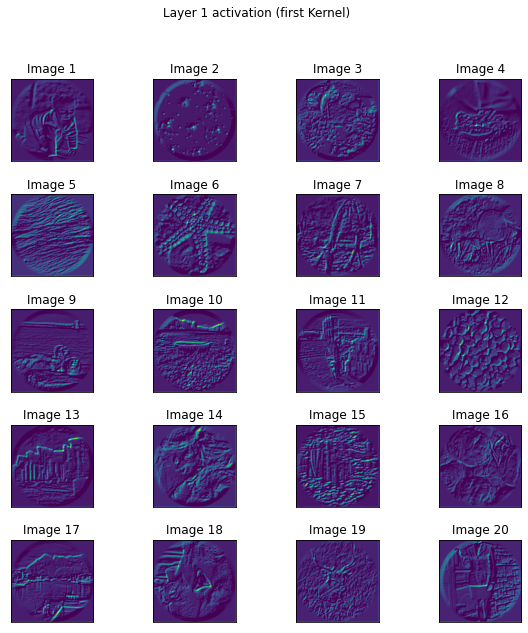

In [9]:
# View the activation at each layer
# Extracts the outputs of a specified layer to view

layer = 3 # set layer to view (below 3 may crash in collab due to low RAM)
activation_model = models.Model(inputs=conv_base.get_input_at(0), outputs= conv_base.layers[layer].output) # Creates a model that will return these outputs, given the model input

layer_activation = activation_model.predict(x_train)  # predict the output

# show responses of layer to 20 images
fig, axs = plt.subplots(5,4, figsize=(10, 10), facecolor='w', edgecolor='k')
fig.subplots_adjust(hspace = .4, wspace=.1)
axs = axs.ravel()

# plot layer activation (first kernel)
kernel = 0 # set kernel to display

for i in range(len(conv_base.layers)-2):
    axs[i].imshow(layer_activation[ i, :, :, kernel], cmap='viridis')
    axs[i].set_title('Image ' + str(i+1))
    axs[i].set_yticklabels([])
    axs[i].set_xticklabels([])
    axs[i].set_yticks([])
    axs[i].set_xticks([])

fig.suptitle('Layer ' + str(layer) + ' activation (first Kernel)')


#### View representation of 20 layers (first kernel of each layer only)

Text(0.5, 0.98, 'Layer activation (first Kernel of each)')

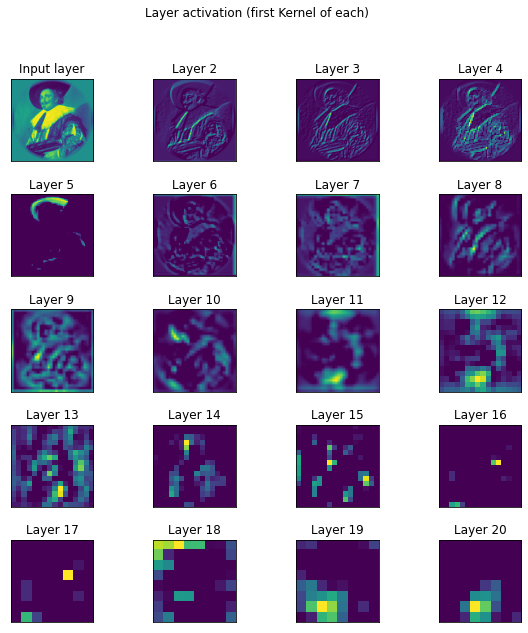

In [21]:
# View all activation examples of all layers (single kernel)

# Extracts the outputs of the top X layers
layer_outputs = [layer.output for layer in conv_base.layers[:len(conv_base.layers)]]

activation_model = models.Model(inputs=conv_base.get_input_at(0), outputs=layer_outputs) # Creates a model that will return these outputs, given the model input

# create image tensor
image_num = 24 # select image
img_tensor = x_train[image_num,:,:,:] 
img_tensor = np.expand_dims(img_tensor, axis=0) # add additional dimension to the image

# predict the output
activations = activation_model.predict(img_tensor)

fig, axs = plt.subplots(5,4, figsize=(10, 10), facecolor='w', edgecolor='k')
fig.subplots_adjust(hspace = .4, wspace=.1)
axs = axs.ravel()

# plot layer activation (first kernel)
kernel = 0 # set kernel to display

for i in range(len(conv_base.layers)-2):
    activation = activations[i]
    axs[i].imshow(activation[ 0, :, :, kernel], cmap='viridis')
    if i == 0:
        axs[i].set_title('Input layer')
    else:
        axs[i].set_title('Layer ' + str(i+1))
    axs[i].set_yticklabels([])
    axs[i].set_xticklabels([])
    axs[i].set_yticks([])
    axs[i].set_xticks([])

fig.suptitle('Layer activation (first Kernel of each)')


### Calculating represenation matrices from multiple layer activation

##### You do not need to run full model training to extract individual layer activations as we used the pre-trained base.

##### Correlation coefficients between each image at multiple layers are calculated and saved to .npy file

In [ ]:
# Extracts the outputs of specified layer - clear output from before, do not need to run full model (layer activation for all layers to avoid RAM crash)

layers = [3] # specify list of layers to calculate representation at

# run loop to generate and save the coeffs
for layer_number in layers:
  activation_model = models.Model(inputs=conv_base.get_input_at(0), outputs= conv_base.layers[layer_number].output) # Creates a model that will return these outputs, given the model input

  # predict the output
  train_activations = activation_model.predict(x_train) 
  test_activations = activation_model.predict(x_test)

  # reshape the activation into a 2D array (dimension 1: images, dimension 2: length of flattened activation from all kernels)
  train_activations =  np.reshape(train_activations,[np.size(train_activations,0),-1])
  test_activations = np.reshape(test_activations,[np.size(test_activations,0),-1])

  # calcualate the correlation coefficient 
  print(train_activations.shape)
  train_coefs = np.corrcoef(train_activations)
  test_coefs = np.corrcoef(test_activations)

  test_activations.shape # print shape

  # save corrcoef at layer
  np.save(str(layer_number) + '_train_coefs',train_coefs)
  np.save(str(layer_number) + '_test_coefs', test_coefs)
